## Early Prediction of Sepsis from Clinical Data

**Objective:** Sepsis detection by using machine learning models based on the physiological data. Particularly, we design and implement a working, open-source algorithm that can, based only on the clinical data provided, automatically identify a patient's risk of sepsis and make a *positive or negative prediction of sepsis*.

**Data:** Data used in the competition is sourced from ICU patients in two separate hospital systems. It consists of Demographics, Vital Signs, and Laboratory values.

**Notebook's plan:**

* Read data, prepare and clean data.

* Analysis and visualize data.

* ML modelisation. 

* Present and compare ML models. 

**Approach:** Ignore the time component and treat record as independently and identically distributed. This approach would help in predicting Sepsis at each hour for any patient.


In [2]:
from os import listdir

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from imblearn.over_sampling import SMOTENC


from plotly.subplots import make_subplots
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

## Data Preparation

### Data reading

The data repository contains one file per patient (e.g., training/p00101.psv ).

Each training data file provides a table with measurements over time. Each column of the table provides a sequence of measurements over time (e.g., heart rate over several hours), where the header of the column describes the measurement. Each row of the table provides a collection of measurements at the same time (e.g., heart rate and oxygen level at the same time)

In [3]:
#Let's take a look at a patient's file p00101.psv
sampl = pd.read_csv('/Users/thientrangbui/Google Drive/Sepsis detection/training/p000001.psv', sep='|')
sampl.head()

HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...   
4  103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN  ...   

   WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
1  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
2  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
3  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
4  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   

   ICULOS  SepsisLabel  
0       1            0  
1       2            0  
2       3            0  
3       4            0  
4       5            0  

[5 rows x 41 columns]

Data includes patient's files recorded from two separate hospitals saved in the two big files tiltled by 'training' and 'training_setB'. Using *listdir* is to read and these two files and write them into a 'psv' file. Then the work easier with the .psv excel file. 

In [ ]:
a_traincsv = listdir('/Users/thientrangbui/Google Drive/Sepsis detection/training/')
b_traincsv = listdir('/Users/thientrangbui/Google Drive/Sepsis detection/training_setB/')


with open("train.psv","wb") as fout:

  for i,csv in enumerate(a_traincsv):
    
      # first file:
    if i == 0:
      with open('/Users/thientrangbui/Google Drive/Sepsis detection/training/' + csv, "rb") as f:
          fout.write(f.read())
      # now the rest:    
    with open('/Users/thientrangbui/Google Drive/Sepsis detection/training/' + csv, "rb") as f:
      next(f) # skip the header
      fout.write(f.read())
      
  for i,csv in enumerate(b_traincsv):
    if i <10000:
      with open('/Users/thientrangbui/Google Drive/Sepsis detection/training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [4]:
#read data
data = pd.read_csv('/Users/thientrangbui/Google Drive/Sepsis detection/train.psv', sep ='|')
data.shape

(1170446, 41)

* **Data size:** includes 1170446 observations and 41 features.

* **Features:**

<ol>
<li>Vital Signs : Heart Rate, Temperature , Blood Pressure, Respiratory rate, etc.</li>
<li>Laboratory Values : Platelet Count, Glucose , Calcium, etc.</li>
<li>Demographics : Age, Gender, Time in ICU , Hospital Admit time, Unit1, Unit2.</li>
</ol>

* **Target feature or Label :** SepsisLabel with 0 (Non-sepsis) and 1 (Sepsis).




In [122]:
data.head()

HR  O2Sat   Temp     SBP   MAP    DBP  Resp  EtCO2  BaseExcess  HCO3  \
0  80.0  100.0  36.50  121.00  58.0  41.00  13.5    NaN         1.0  25.0   
1  76.0  100.0  36.25  113.25  61.0  41.50  12.0    NaN         1.0  25.0   
2  80.0  100.0  36.25  132.75  71.5  46.25  12.0    NaN         NaN   NaN   
3  78.0  100.0  36.10  103.50  58.0  43.00  12.0    NaN        -3.0   NaN   
4  74.0  100.0  36.00  128.75  69.5  44.50  12.5    NaN        -3.0   NaN   

   ...  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...  9.9       223.0      160.0  77.27       1    0.0    1.0       -69.14   
1  ...  9.9         NaN        NaN  77.27       1    0.0    1.0       -69.14   
2  ...  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   
3  ...  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   
4  ...  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   

   ICULOS  SepsisLabel  
0       3            0  
1       4            0  
2       5            0  
3       6            0  
4       7            0  

[5 rows x 41 columns]

### Data cleaning

We show the missing data percent in each feature to see which feature we should keep to go far with our problem. 

* First, we list missing data by ascending them to easily folow which ones are missing most. 

* Then we show them on a figure to have a global view of missing values within separate features. A high Percentage of missing data is in most of the features. 

In [5]:
# missing data
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.sort_values(ascending=False)

missing_data = data_na.to_frame().reset_index()
missing_data.columns = ['Column_Name','Missing Ratio']

In [124]:
missing_data

Column_Name  Missing Ratio
0   Bilirubin_direct      99.820667
1          TroponinI      99.324958
2         Fibrinogen      99.311544
3    Bilirubin_total      98.606514
4       Alkalinephos      98.450932
5                AST      98.429146
6              EtCO2      97.647051
7            Lactate      97.091023
8                PTT      96.417092
9               SaO2      96.039715
10         Phosphate      95.637390
11              HCO3      94.501498
12           Calcium      94.454763
13          Chloride      94.193666
14         Platelets      93.875668
15        Creatinine      93.731791
16             PaCO2      93.371672
17               WBC      93.228137
18         Magnesium      93.196269
19        BaseExcess      92.882969
20               BUN      92.708506
21               Hgb      92.131888
22                pH      91.551084
23         Potassium      90.189979
24               Hct      90.165971
25              FiO2      89.707770
26           Glucose      84.596641
27              Temp      66.274480
28             Unit1      42.694921
29             Unit2      42.694921
30               DBP      37.032123
31               SBP      14.801281
32              Resp      13.514677
33             O2Sat      12.694135
34               MAP      11.714423
35                HR       9.168983
36       HospAdmTime       0.000684
37            ICULOS       0.000000
38               Age       0.000000
39            Gender       0.000000
40       SepsisLabel       0.000000

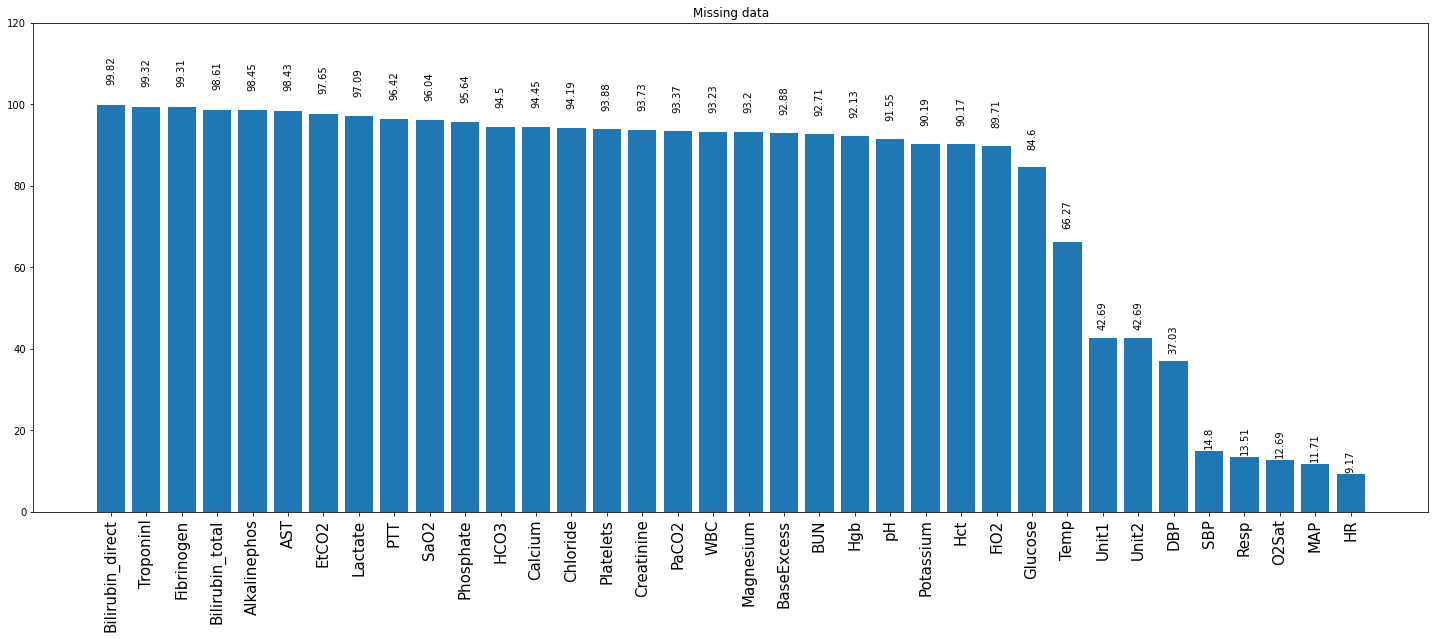

In [6]:
# missing data graph
missing_data_plot = missing_data[missing_data['Missing Ratio'] > 5]

fig, ax = plt.subplots(figsize=(25,9))

bar_x = list(range(1,37))
bar_height = np.asarray(missing_data_plot[['Missing Ratio']]).reshape(-1)
bar_tick_label = np.asarray(missing_data_plot[['Column_Name']]).reshape(-1)
bar_label = np.asarray(round(missing_data_plot[['Missing Ratio']],2)).reshape(-1)

bar_plot = plt.bar(bar_x,bar_height)
plt.xticks(bar_x, bar_tick_label, fontsize=15, rotation=90)
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=90)

autolabel(bar_plot)
plt.ylim(0,120)


plt.title('Missing data')

plt.show()

We consider only features which their proportion of missing data are less than 90%. On the other words, we remove features which miss too much data overing 90%. 

In [9]:
# keeped features
selected_cols = list(data_na[data_na < 90].index)
selected_cols

['FiO2',
 'Glucose',
 'Temp',
 'Unit1',
 'Unit2',
 'DBP',
 'SBP',
 'Resp',
 'O2Sat',
 'MAP',
 'HR',
 'HospAdmTime',
 'ICULOS',
 'Age',
 'Gender',
 'SepsisLabel']

In [10]:
filter_data = data[selected_cols]
filter_data.head()

FiO2  Glucose   Temp  Unit1  Unit2    DBP     SBP  Resp  O2Sat   MAP    HR  \
0   1.0    107.0  36.50    0.0    1.0  41.00  121.00  13.5  100.0  58.0  80.0   
1   0.5      NaN  36.25    0.0    1.0  41.50  113.25  12.0  100.0  61.0  76.0   
2   NaN      NaN  36.25    0.0    1.0  46.25  132.75  12.0  100.0  71.5  80.0   
3   NaN    112.5  36.10    0.0    1.0  43.00  103.50  12.0  100.0  58.0  78.0   
4   NaN      NaN  36.00    0.0    1.0  44.50  128.75  12.5  100.0  69.5  74.0   

   HospAdmTime  ICULOS    Age  Gender  SepsisLabel  
0       -69.14       3  77.27       1            0  
1       -69.14       4  77.27       1            0  
2       -69.14       5  77.27       1            0  
3       -69.14       6  77.27       1            0  
4       -69.14       7  77.27       1            0

Besides that, considering the relative between FiO2 - the fraction if inspired oxigen (89.70% missing values) and PaCO2 (removed feature) - Partial pressure of carbon dioxide from arterial blood, we drop also FiO2.

In [11]:
filter_data.drop(['FiO2'], axis=1, inplace=True)

In [12]:
filter_data.shape # 14 refer features and 1 target feature

(1170446, 15)

In [15]:
# our dataset after filtering
filter_data.head()

Glucose   Temp  Unit1  Unit2    DBP     SBP  Resp  O2Sat   MAP    HR  \
0    107.0  36.50    0.0    1.0  41.00  121.00  13.5  100.0  58.0  80.0   
1      NaN  36.25    0.0    1.0  41.50  113.25  12.0  100.0  61.0  76.0   
2      NaN  36.25    0.0    1.0  46.25  132.75  12.0  100.0  71.5  80.0   
3    112.5  36.10    0.0    1.0  43.00  103.50  12.0  100.0  58.0  78.0   
4      NaN  36.00    0.0    1.0  44.50  128.75  12.5  100.0  69.5  74.0   

   HospAdmTime  ICULOS    Age  Gender  SepsisLabel  
0       -69.14       3  77.27       1            0  
1       -69.14       4  77.27       1            0  
2       -69.14       5  77.27       1            0  
3       -69.14       6  77.27       1            0  
4       -69.14       7  77.27       1            0

In [13]:
filter_data.describe()

Glucose           Temp          Unit1          Unit2  \
count  180288.000000  394739.000000  670725.000000  670725.000000   
mean      136.100398      36.992621       0.498735       0.501265   
std        51.782275       0.773387       0.499999       0.499999   
min        10.000000      20.900000       0.000000       0.000000   
25%       106.000000      36.500000       0.000000       0.000000   
50%       126.000000      37.000000       0.000000       1.000000   
75%       152.000000      37.500000       1.000000       1.000000   
max       988.000000      42.220000       1.000000       1.000000   

                 DBP            SBP          Resp         O2Sat           MAP  \
count  737005.000000  997205.000000  1.012264e+06  1.021868e+06  1.033335e+06   
mean       62.737802     122.870458  1.873430e+01  9.721921e+01  8.115659e+01   
std        13.659581      22.691152  5.196008e+00  2.932593e+00  1.598641e+01   
min        20.000000      20.000000  1.000000e+00  2.000000e+01  2.000000e+01   
25%        53.000000     106.000000  1.500000e+01  9.600000e+01  7.000000e+01   
50%        61.000000     120.000000  1.800000e+01  9.800000e+01  7.900000e+01   
75%        70.000000     137.000000  2.200000e+01  9.950000e+01  9.000000e+01   
max       298.000000     296.000000  9.900000e+01  1.000000e+02  3.000000e+02   

                 HR   HospAdmTime        ICULOS           Age        Gender  \
count  1.063128e+06  1.170438e+06  1.170446e+06  1.170446e+06  1.170446e+06   
mean   8.467505e+01 -5.565221e+01  2.694665e+01  6.240979e+01  5.652051e-01   
std    1.722118e+01  1.708627e+02  2.849355e+01  1.634683e+01  4.957303e-01   
min    2.000000e+01 -5.366860e+03  1.000000e+00  1.400000e+01  0.000000e+00   
25%    7.200000e+01 -4.395000e+01  1.100000e+01  5.200000e+01  0.000000e+00   
50%    8.400000e+01 -4.990000e+00  2.100000e+01  6.429000e+01  1.000000e+00   
75%    9.600000e+01 -3.000000e-02  3.500000e+01  7.500000e+01  1.000000e+00   
max    2.800000e+02  2.399000e+01  3.360000e+02  1.000000e+02  1.000000e+00   

        SepsisLabel  
count  1.170446e+06  
mean   1.920635e-02  
std    1.372497e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00

### Data's features understanding



In [16]:
filter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170446 entries, 0 to 1170445
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Glucose      180288 non-null   float64
 1   Temp         394739 non-null   float64
 2   Unit1        670725 non-null   float64
 3   Unit2        670725 non-null   float64
 4   DBP          737005 non-null   float64
 5   SBP          997205 non-null   float64
 6   Resp         1012264 non-null  float64
 7   O2Sat        1021868 non-null  float64
 8   MAP          1033335 non-null  float64
 9   HR           1063128 non-null  float64
 10  HospAdmTime  1170438 non-null  float64
 11  ICULOS       1170446 non-null  int64  
 12  Age          1170446 non-null  float64
 13  Gender       1170446 non-null  int64  
 14  SepsisLabel  1170446 non-null  int64  
dtypes: float64(12), int64(3)
memory usage: 133.9 MB


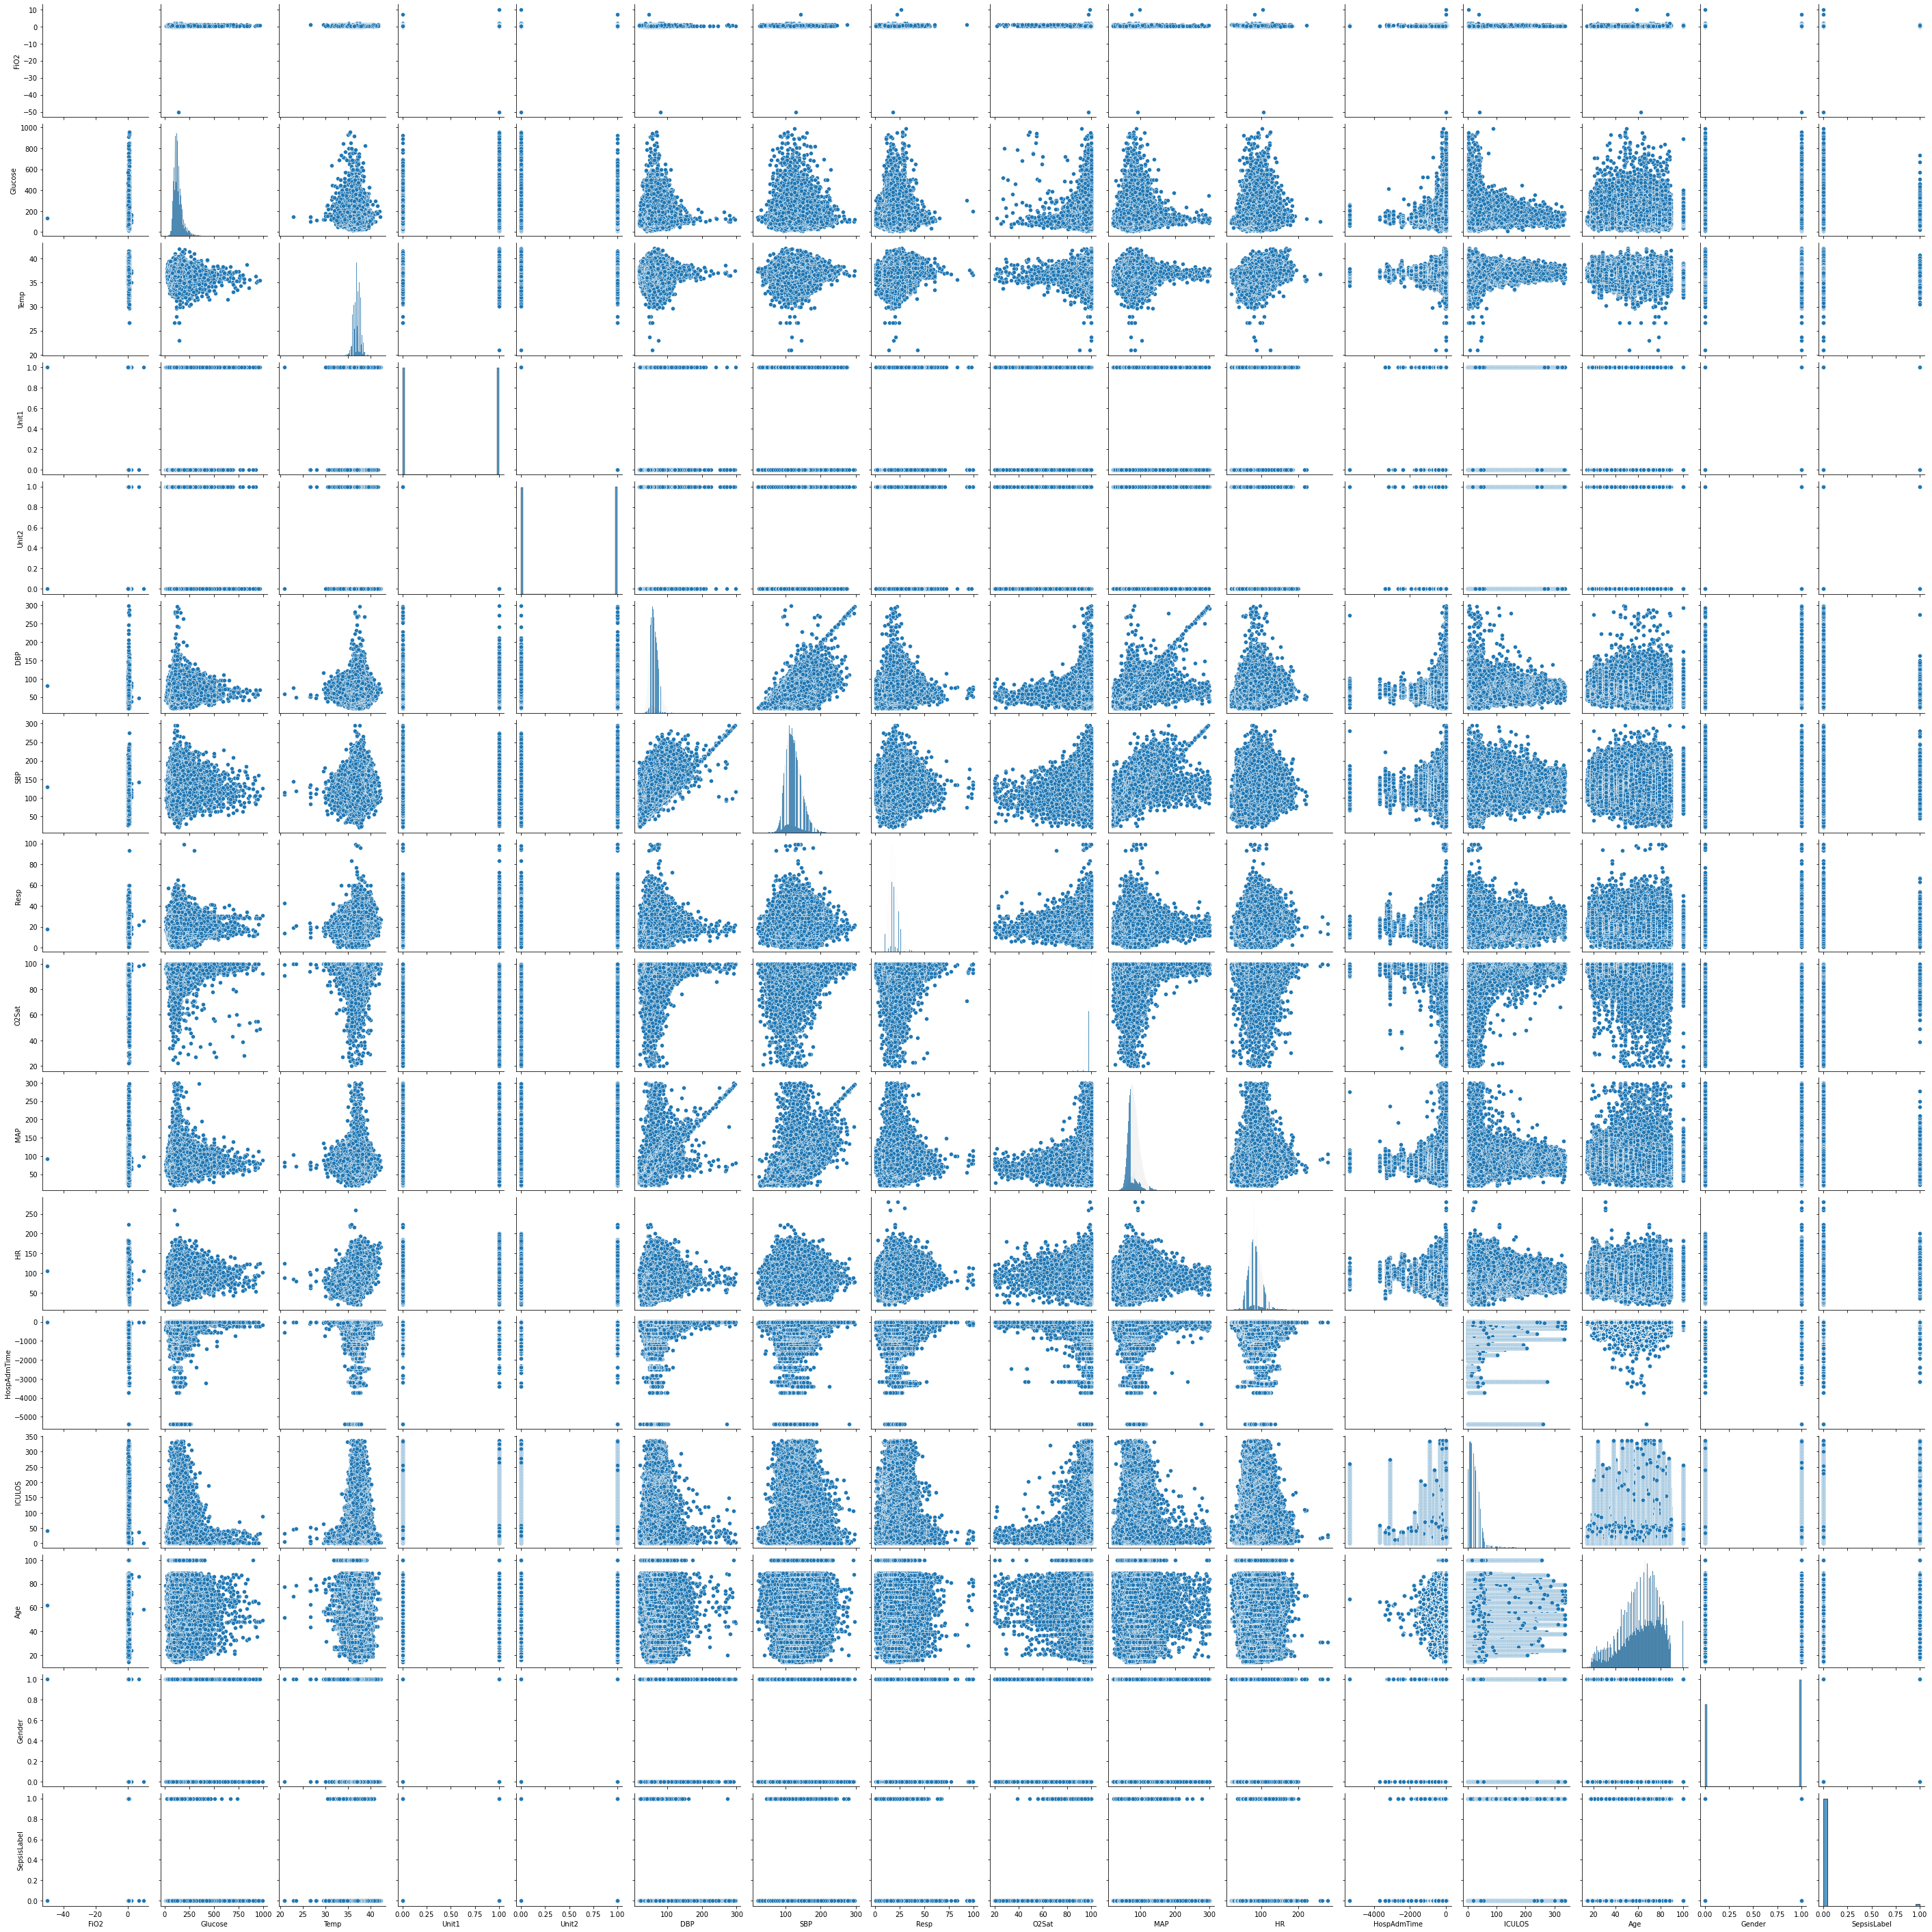

In [73]:
sns.pairplot(filter_train)

<ol>
<li>SepsisLabel: target colunm that we want to classify patients having sepsis - SepsisLabel = 1, or having no sepsis - SepsisLabel = 0.</li>

<li>Demographics:</li>

<ul>
<li>Age: Years (100 for patients 90 or above)</li>
<li>Gender: Female (0) or Male (1) </li>
    ==> *Gender should be a categorical feature*
<li>Unit1: Administrative identifier for ICU unit (Medical Intensive Care Unit)</li>
    ==> *Unit1 should be a categorical feature*
<li>Unit2: Administrative identifier for ICU unit (Surgical Intensive Care Unit)</li>
    ==> *Unit1 should be a categorical feature*
<li>HospAdmTime: Hours between hospital admit and ICU admit</li>
<li>ICULOS: ICU length-of-stay (hours since ICU admit)</li>
</ul>

<li>Vital signs</li>

<ul>
<li>DBP: Diastolic BP (mm Hg)</li>
<li>SBP: Systolic BP (mm Hg)</li>
<li>O2Sat: Pulse oximetry (%)</li>
<li>HR: Heart rate (beats per minute)</li>
<li>Temp: Temperature (Deg C)</li>
<li>MAP: Mean arterial pressure (mm Hg)</li>
</ul>
    
<li>Laboratory values</li>
    
<ul>
<li>Glucose: Serum glucose (mg/dL)</li>
</ul>

In [20]:
# take a list of numerical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_list=filter_data.select_dtypes(include=numerics).columns
numerical_list

Index(['Glucose', 'Temp', 'Unit1', 'Unit2', 'DBP', 'SBP', 'Resp', 'O2Sat',
       'MAP', 'HR', 'HospAdmTime', 'ICULOS', 'Age', 'Gender', 'SepsisLabel'],
      dtype='object')

In [21]:
# Gender, Unit1 and Unit2 should be categorical features
numerical_list = numerical_list.drop(['Gender','Unit1', 'Unit2'])
numerical_list

Index(['Glucose', 'Temp', 'DBP', 'SBP', 'Resp', 'O2Sat', 'MAP', 'HR',
       'HospAdmTime', 'ICULOS', 'Age', 'SepsisLabel'],
      dtype='object')

In [22]:
#let's exchange some numerical features to object forms (categorical features)
int_to_object = ['Gender','Unit1', 'Unit2','SepsisLabel']

for feature in int_to_object:
    filter_data[feature] = filter_data[feature].astype(object)

In [132]:
filter_data.info() #verify again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170446 entries, 0 to 1170445
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   FiO2         120465 non-null   float64
 1   Glucose      180288 non-null   float64
 2   Temp         394739 non-null   float64
 3   Unit1        670725 non-null   object 
 4   Unit2        670725 non-null   object 
 5   DBP          737005 non-null   float64
 6   SBP          997205 non-null   float64
 7   Resp         1012264 non-null  float64
 8   O2Sat        1021868 non-null  float64
 9   MAP          1033335 non-null  float64
 10  HR           1063128 non-null  float64
 11  HospAdmTime  1170438 non-null  float64
 12  ICULOS       1170446 non-null  int64  
 13  Age          1170446 non-null  float64
 14  Gender       1170446 non-null  object 
 15  SepsisLabel  1170446 non-null  object 
dtypes: float64(11), int64(1), object(4)
memory usage: 142.9+ MB


In [23]:
category=['object']
categorical_list=filter_data.select_dtypes(include=category).columns
categorical_list

Index(['Unit1', 'Unit2', 'Gender', 'SepsisLabel'], dtype='object')

### Filling in for NAs values

A copy version of data is created to keep the orginal dataset in the case that we want to work on the original data. 

Then, we fill NAs positions corresponding separately to numerical and categorical features in the data copied version.

In [58]:
# a copy version of data, we want to fill NAs values and create new ennigeering features
filter_data_copy = filter_data.copy()

#### Filling in for numerical NAs values

In [59]:
# numerical features
filter_data_copy[numerical_list].isna().sum().sort_values(ascending=False)

Glucose        990158
Temp           775707
DBP            433441
SBP            173241
Resp           158182
O2Sat          148578
MAP            137111
HR             107318
HospAdmTime         8
SepsisLabel         0
Age                 0
ICULOS              0
dtype: int64

In [60]:
#filling the missing values with mean
index_sepsis1=filter_data_copy[filter_data_copy['SepsisLabel'] == 1].index.tolist()
index_sepsis0=filter_data_copy[filter_data_copy['SepsisLabel'] == 0].index.tolist()

for col in numerical_list:
    filter_data_copy.loc[index_sepsis1,col]=filter_data_copy.loc[index_sepsis1,col].fillna(filter_data_copy.loc[index_sepsis1,col].mean())
    
for col in numerical_list:
    filter_data_copy.loc[index_sepsis0,col]=filter_data_copy.loc[index_sepsis0,col].fillna(filter_data_copy.loc[index_sepsis0,col].mean())


In [61]:
# check again the numerical missing values after filling
filter_data_copy[numerical_list].isna().sum()

Glucose        0
Temp           0
DBP            0
SBP            0
Resp           0
O2Sat          0
MAP            0
HR             0
HospAdmTime    0
ICULOS         0
Age            0
SepsisLabel    0
dtype: int64

#### Filling in for categorical NAs 

In [62]:
categorical_list

Index(['Unit1', 'Unit2', 'Gender', 'SepsisLabel'], dtype='object')

In [63]:
# Categorical 
filter_data_copy[categorical_list].isna().sum()

Unit1          499721
Unit2          499721
Gender              0
SepsisLabel         0
dtype: int64

In [64]:
# replace NAs positions by a representative number, such as 2, cause the two already characteristics
# are 0 and 1
for col in categorical_list:
    filter_data_copy[col].fillna(2,inplace=True)

In [65]:
# Categorical 
filter_data_copy[categorical_list].isna().sum()

Unit1          0
Unit2          0
Gender         0
SepsisLabel    0
dtype: int64

#### Enginering feature

According to the National Institute of General Medical Sciences, an aging population get risk of sepsis. This makes age an important feature, so we create an enginering feature for Age class deviding into 4 separate groups: less than 65 years old, from 65 - 74 years old, from 75 - 84 years old and greater than 85 years old.

<AxesSubplot:xlabel='Age'>

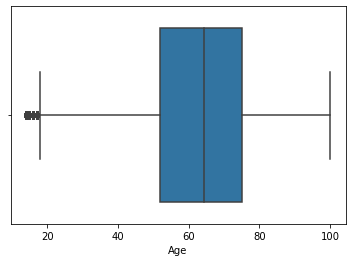

In [66]:
sns.boxplot(filter_data_copy['Age'])

In [67]:
# Age groups
def conditions(s):
    if (s['Age'] < 60):
        return 'Age_less_60'
    else:
        return 'Age60_older'

In [68]:
filter_data_copy['Class_Age'] = filter_data_copy.apply(conditions, axis=1)

In [69]:
filter_data_copy.head()

Glucose   Temp  Unit1  Unit2    DBP     SBP  Resp  O2Sat   MAP    HR  \
0  107.000000  36.50    0.0    1.0  41.00  121.00  13.5  100.0  58.0  80.0   
1  136.030007  36.25    0.0    1.0  41.50  113.25  12.0  100.0  61.0  76.0   
2  136.030007  36.25    0.0    1.0  46.25  132.75  12.0  100.0  71.5  80.0   
3  112.500000  36.10    0.0    1.0  43.00  103.50  12.0  100.0  58.0  78.0   
4  136.030007  36.00    0.0    1.0  44.50  128.75  12.5  100.0  69.5  74.0   

   HospAdmTime  ICULOS    Age  Gender  SepsisLabel    Class_Age  
0       -69.14       3  77.27       1            0  Age60_older  
1       -69.14       4  77.27       1            0  Age60_older  
2       -69.14       5  77.27       1            0  Age60_older  
3       -69.14       6  77.27       1            0  Age60_older  
4       -69.14       7  77.27       1            0  Age60_older

In [70]:
# exchange the feature Gender from the numeric representive into Male and Female presents
# Age groups
def conditions(s):
    if (s['Gender'] == 0):
        return 'Female'
    else:
        return 'Male'

In [71]:
filter_data_copy['Gender_'] = filter_data_copy.apply(conditions, axis=1)

In [72]:
filter_data_copy.drop(['Gender'], axis=1, inplace=True)

In [73]:
#let's exchange some numerical features to object forms
int_to_object = ['Gender_','Unit1', 'Unit2','SepsisLabel']

for feature in int_to_object:
    filter_data_copy[feature] = filter_data_copy[feature].astype(object)

In [74]:
filter_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170446 entries, 0 to 1170445
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Glucose      1170446 non-null  float64
 1   Temp         1170446 non-null  float64
 2   Unit1        1170446 non-null  object 
 3   Unit2        1170446 non-null  object 
 4   DBP          1170446 non-null  float64
 5   SBP          1170446 non-null  float64
 6   Resp         1170446 non-null  float64
 7   O2Sat        1170446 non-null  float64
 8   MAP          1170446 non-null  float64
 9   HR           1170446 non-null  float64
 10  HospAdmTime  1170446 non-null  float64
 11  ICULOS       1170446 non-null  int64  
 12  Age          1170446 non-null  float64
 13  SepsisLabel  1170446 non-null  object 
 14  Class_Age    1170446 non-null  object 
 15  Gender_      1170446 non-null  object 
dtypes: float64(10), int64(1), object(5)
memory usage: 142.9+ MB


In [75]:
# our data after filling in NAs values and creating a new enginering feature
filter_data_copy.head()

Glucose   Temp Unit1 Unit2    DBP     SBP  Resp  O2Sat   MAP    HR  \
0  107.000000  36.50     0     1  41.00  121.00  13.5  100.0  58.0  80.0   
1  136.030007  36.25     0     1  41.50  113.25  12.0  100.0  61.0  76.0   
2  136.030007  36.25     0     1  46.25  132.75  12.0  100.0  71.5  80.0   
3  112.500000  36.10     0     1  43.00  103.50  12.0  100.0  58.0  78.0   
4  136.030007  36.00     0     1  44.50  128.75  12.5  100.0  69.5  74.0   

   HospAdmTime  ICULOS    Age SepsisLabel    Class_Age Gender_  
0       -69.14       3  77.27           0  Age60_older    Male  
1       -69.14       4  77.27           0  Age60_older    Male  
2       -69.14       5  77.27           0  Age60_older    Male  
3       -69.14       6  77.27           0  Age60_older    Male  
4       -69.14       7  77.27           0  Age60_older    Male

## Data visualisation

### Sepsis and Age

Text(0.5, 1.0, 'Sepsis and non-sepsis with age')

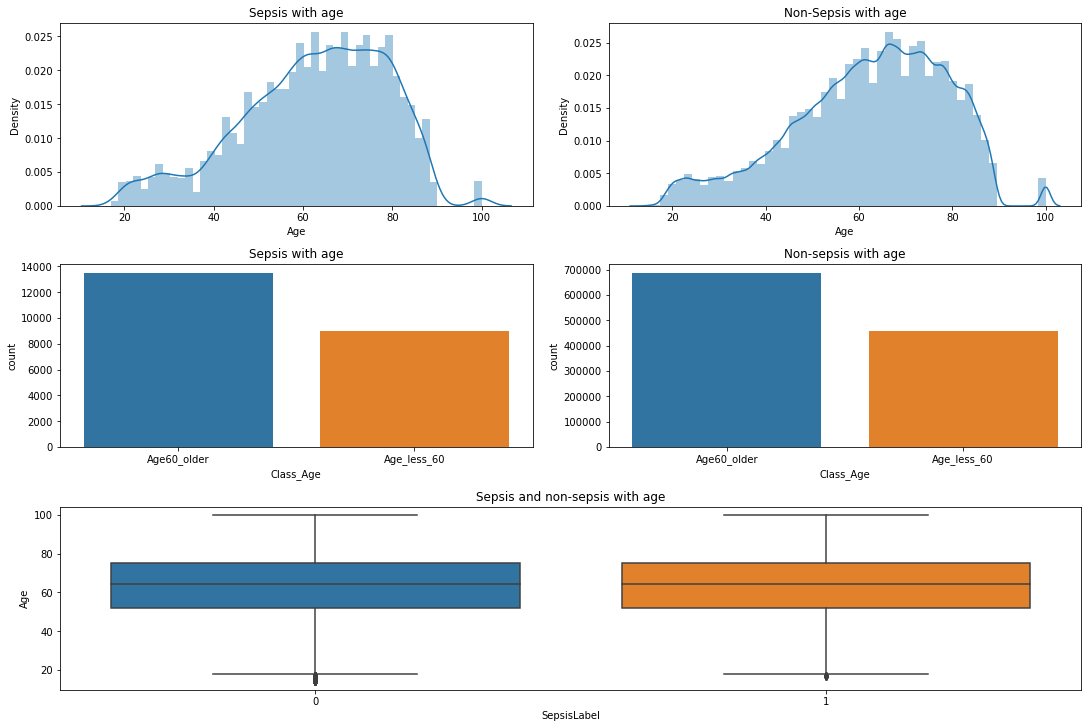

In [82]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(3, 2,figure=fig)

# density plots
plt.subplot(gs[0,0])
a1 =  sns.distplot(filter_data_copy.loc[index_sepsis1,'Age'], axlabel='Age');
a1.set_title("Sepsis with age")

plt.subplot(gs[0,1])
a2 =  sns.distplot(filter_data_copy.loc[index_sepsis0,'Age'], axlabel='Age');
a2.set_title("Non-Sepsis with age")

# Count plots
plt.subplot(gs[1,0])
a3=sns.countplot(x="Class_Age",data=filter_data_copy.loc[index_sepsis1],order = filter_data_copy['Class_Age'].value_counts().index)
a3.set_title("Sepsis with age")

plt.subplot(gs[1,1])
a4=sns.countplot(x="Class_Age",data=filter_data_copy.loc[index_sepsis0],order = filter_data_copy['Class_Age'].value_counts().index)
a4.set_title("Non-sepsis with age")

# box plots
plt.subplot(gs[2,:])
a5=sns.boxplot(y="Age",x = 'SepsisLabel',data=filter_data_copy)
a5.set_title("Sepsis and non-sepsis with age")

### Sepsis and Gender

Text(0.5, 1.0, 'Sepsis and non-sepsis with age and gender')

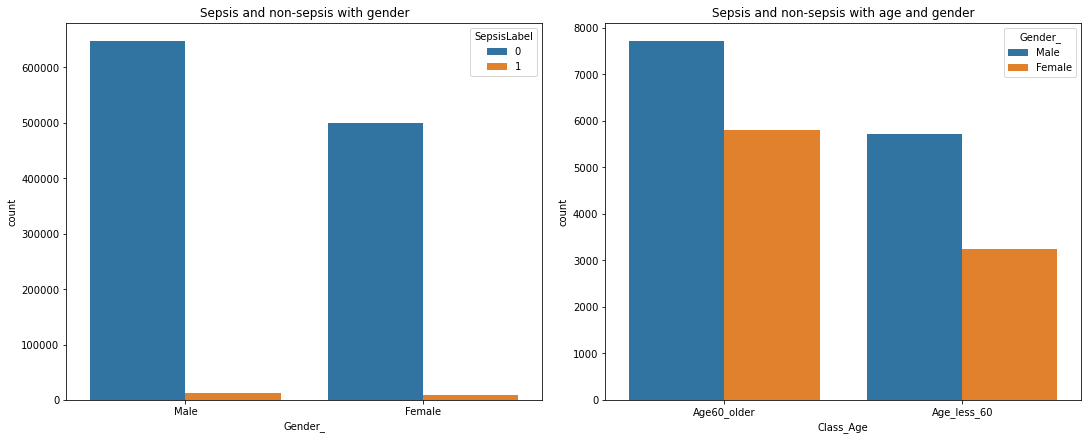

In [110]:
fig2 = plt.figure(constrained_layout=True,figsize=(15,6))
gs2 = gridspec.GridSpec(1, 2,figure=fig2)

# Count plots
plt.subplot(gs2[0,0])
a1=sns.countplot(x="Gender_",hue = 'SepsisLabel',data=filter_data_copy)
a1.set_title("Sepsis and non-sepsis with gender")

plt.subplot(gs2[0,1])
a2=sns.countplot(x="Class_Age",hue = 'Gender_',data=filter_data_copy.loc[index_sepsis1])
a2.set_title("Sepsis and non-sepsis with age and gender")

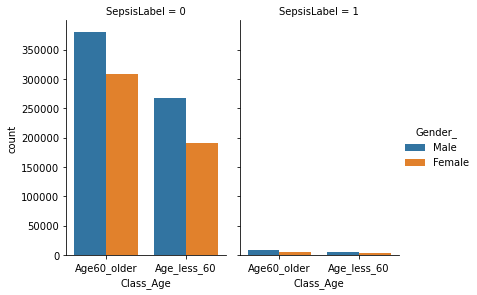

In [92]:
a3 = sns.catplot(x="Class_Age", hue="Gender_", col="SepsisLabel",data=filter_data_copy,
                kind="count",height=4, aspect=.7);

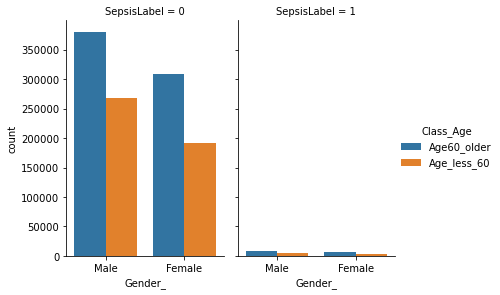

In [111]:
a3 = sns.catplot(x="Gender_", hue="Class_Age", col="SepsisLabel",data=filter_data_copy,
                kind="count",height=4, aspect=.7);

### Sepsis and ICULOS (intensitive case unit lenght of stay hours since ICU admit)

Text(0.5, 1.0, 'Sepsis and non-sepsis with ICULOS and age')

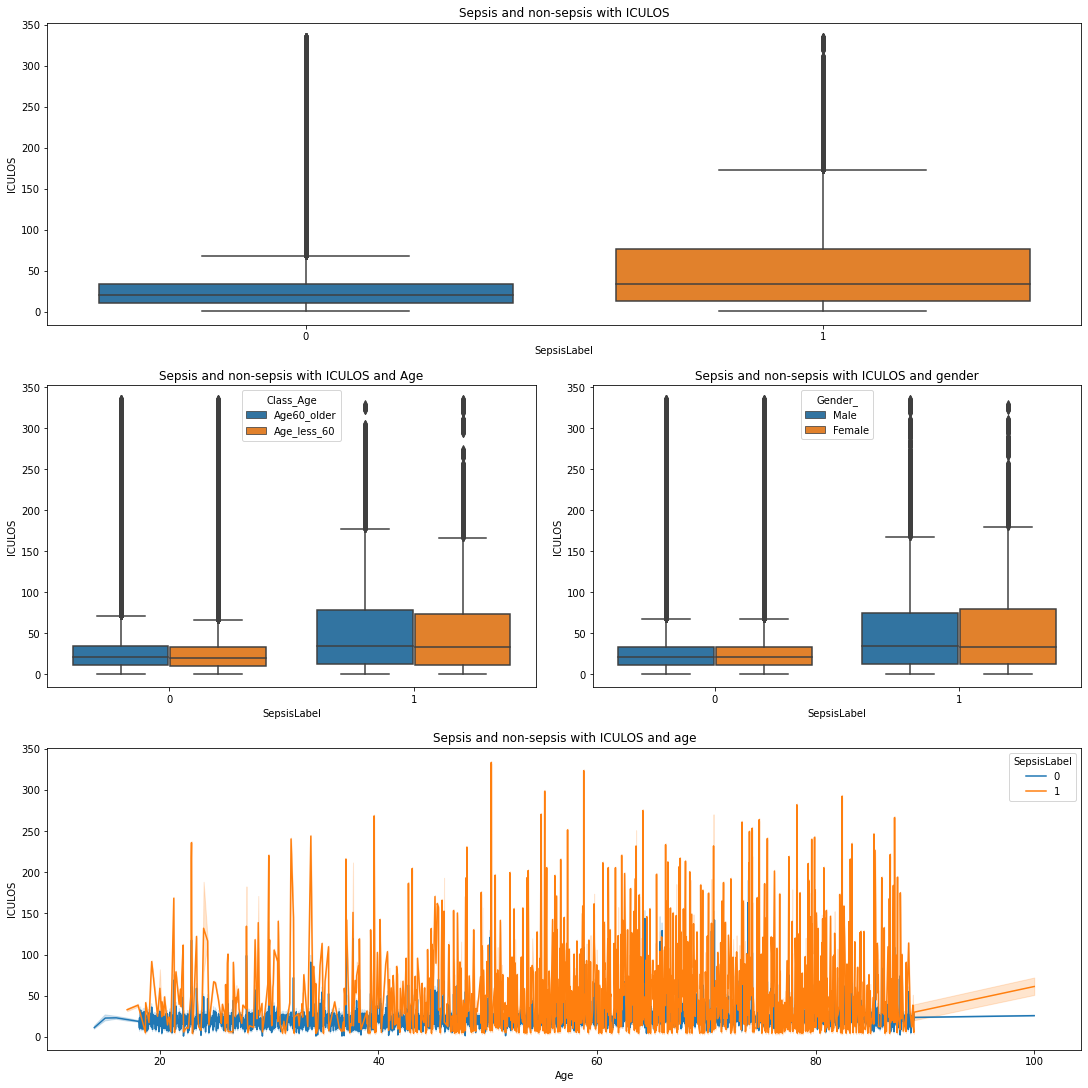

In [116]:
fig = plt.figure(constrained_layout=True,figsize=(15,15))
gs = gridspec.GridSpec(3, 2,figure=fig)


plt.subplot(gs[0,:])
a5=sns.boxplot(y="ICULOS",x = 'SepsisLabel',data=filter_data_copy)
a5.set_title("Sepsis and non-sepsis with ICULOS")


plt.subplot(gs[1,0])
ax1=sns.boxplot(y="ICULOS",x = 'SepsisLabel',hue='Class_Age',data=filter_data_copy)
ax1.set_title("Sepsis and non-sepsis with ICULOS and Age")

plt.subplot(gs[1,1])
ax2=sns.boxplot(y="ICULOS",x = 'SepsisLabel',hue='Gender_',data=filter_data_copy)
ax2.set_title("Sepsis and non-sepsis with ICULOS and gender")


plt.subplot(gs[2,:])
a5=sns.lineplot(data=filter_data_copy, x="Age", y="ICULOS", hue="SepsisLabel")
a5.set_title("Sepsis and non-sepsis with ICULOS and age")

### Sepsis and HospAdmTime - Hours between hospital admit and ICU admit


Text(0.5, 1.0, 'Sepsis and non-sepsis with HospAdmTime')

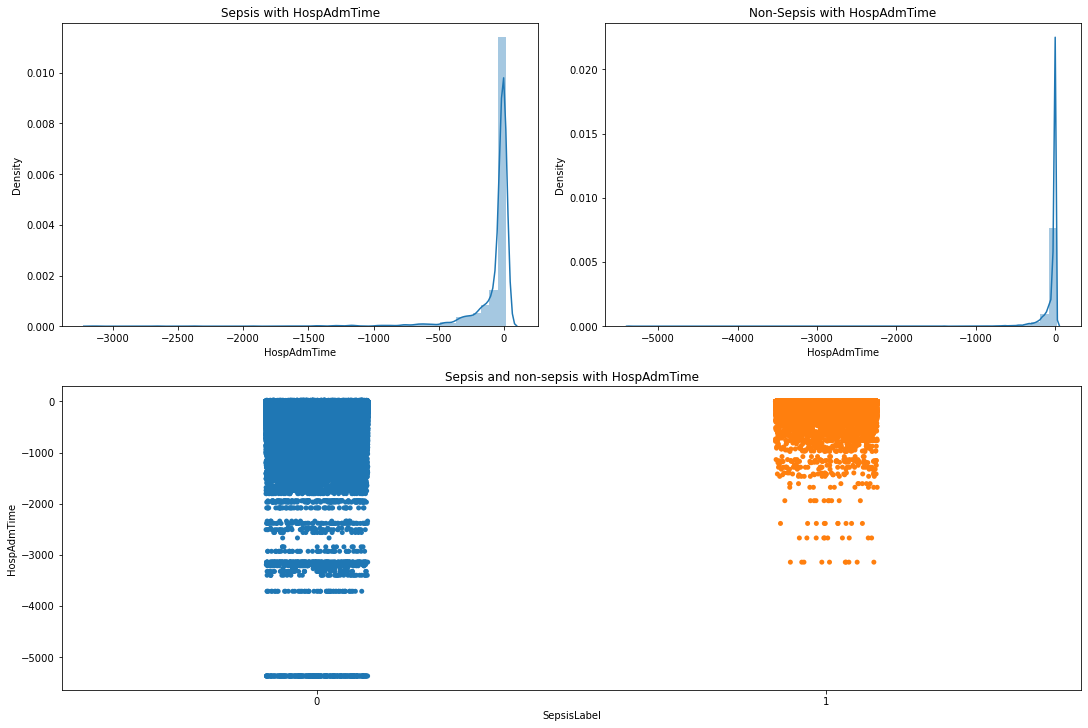

In [121]:
#HospAdmTime
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(2, 2,figure=fig)

plt.subplot(gs[0,0])
a1 =  sns.distplot(filter_data_copy.loc[index_sepsis1,'HospAdmTime'], axlabel='HospAdmTime');
a1.set_title("Sepsis with HospAdmTime")

plt.subplot(gs[0,1])
a2 =  sns.distplot(filter_data_copy.loc[index_sepsis0,'HospAdmTime'], axlabel='HospAdmTime');
a2.set_title("Non-Sepsis with HospAdmTime")


plt.subplot(gs[1,:])
a5=sns.stripplot(data=filter_data_copy,x='SepsisLabel',y="HospAdmTime")
a5.set_title("Sepsis and non-sepsis with HospAdmTime")


### Sepsis and Unit1 and Unit2

Text(0.5, 1.0, 'Sepsis and non-sepsis with Unit1')

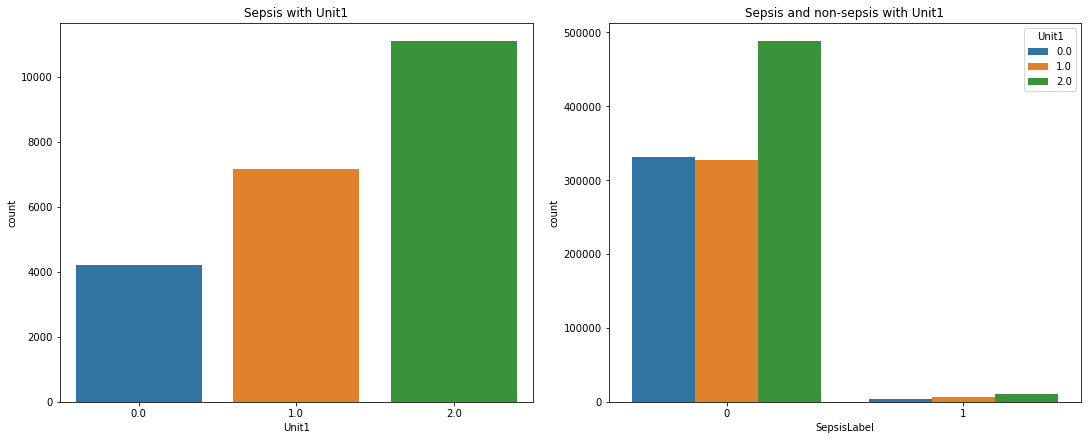

In [118]:
#Unit1
fig = plt.figure(constrained_layout=True,figsize=(15,6))
gs = gridspec.GridSpec(1, 2,figure=fig)

plt.subplot(gs[0,0])
ax1=sns.countplot(x="Unit1",data=filter_data_copy.loc[index_sepsis1])
ax1.set_title("Sepsis with Unit1")

plt.subplot(gs[0,1])
ax2=sns.countplot(x="SepsisLabel", hue="Unit1",data=filter_data_copy)
ax2.set_title("Sepsis and non-sepsis with Unit1")

Text(0.5, 1.0, 'Sepsis and non-sepsis with Unit2')

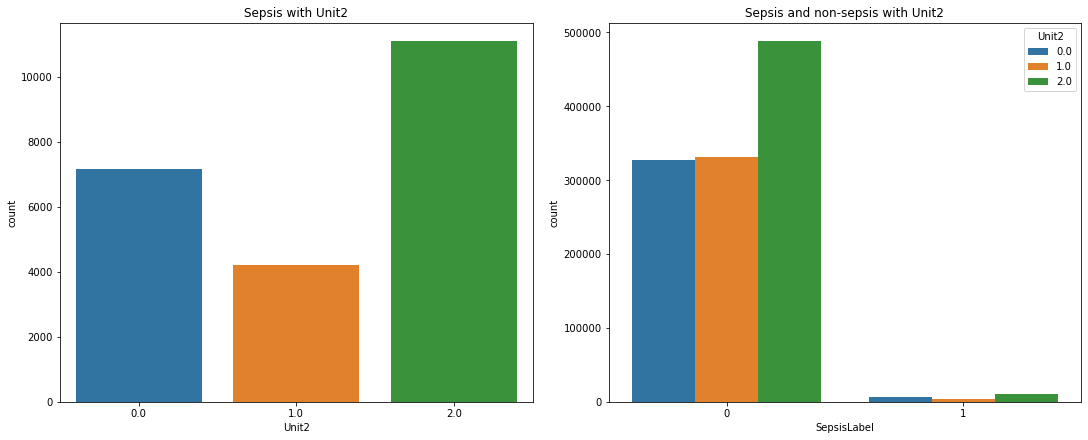

In [119]:
#Unit2
fig = plt.figure(constrained_layout=True,figsize=(15,6))
gs = gridspec.GridSpec(1, 2,figure=fig)

plt.subplot(gs[0,0])
ax1=sns.countplot(x="Unit2",data=filter_data_copy.loc[index_sepsis1])
ax1.set_title("Sepsis with Unit2")

plt.subplot(gs[0,1])
ax2=sns.countplot(x="SepsisLabel", hue="Unit2",data=filter_data_copy)
ax2.set_title("Sepsis and non-sepsis with Unit2")


### Sepsis with Heart rate

Text(0.5, 1.0, 'Non-sepsis with HR')

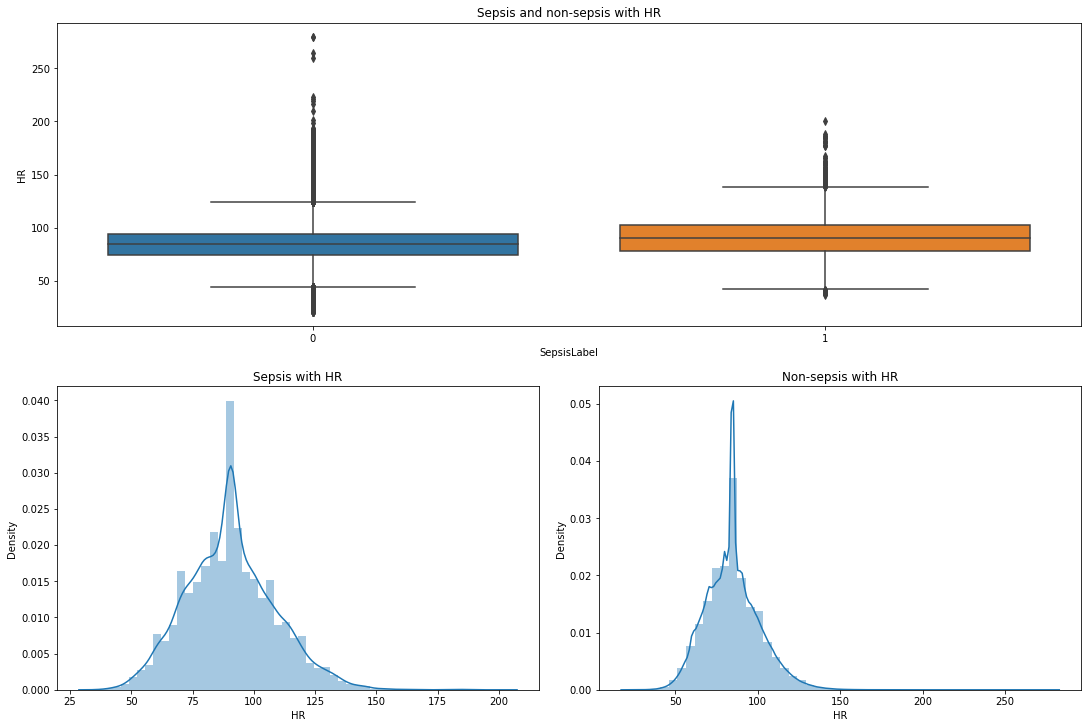

In [123]:
#HR
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(2, 2,figure=fig)

plt.subplot(gs[0,:])
ax1=sns.boxplot(y="HR",x = 'SepsisLabel',data=filter_data_copy)
ax1.set_title("Sepsis and non-sepsis with HR")

plt.subplot(gs[1,0])
ax2=sns.distplot(filter_data_copy.loc[index_sepsis1,'HR'], axlabel='HR')
ax2.set_title("Sepsis with HR")

plt.subplot(gs[1,1])
ax3=sns.distplot(filter_data_copy.loc[index_sepsis0,'HR'], axlabel='HR')
ax3.set_title("Non-sepsis with HR")

Text(0.5, 1.0, 'Sepsis and non-sepsis with HR and age')

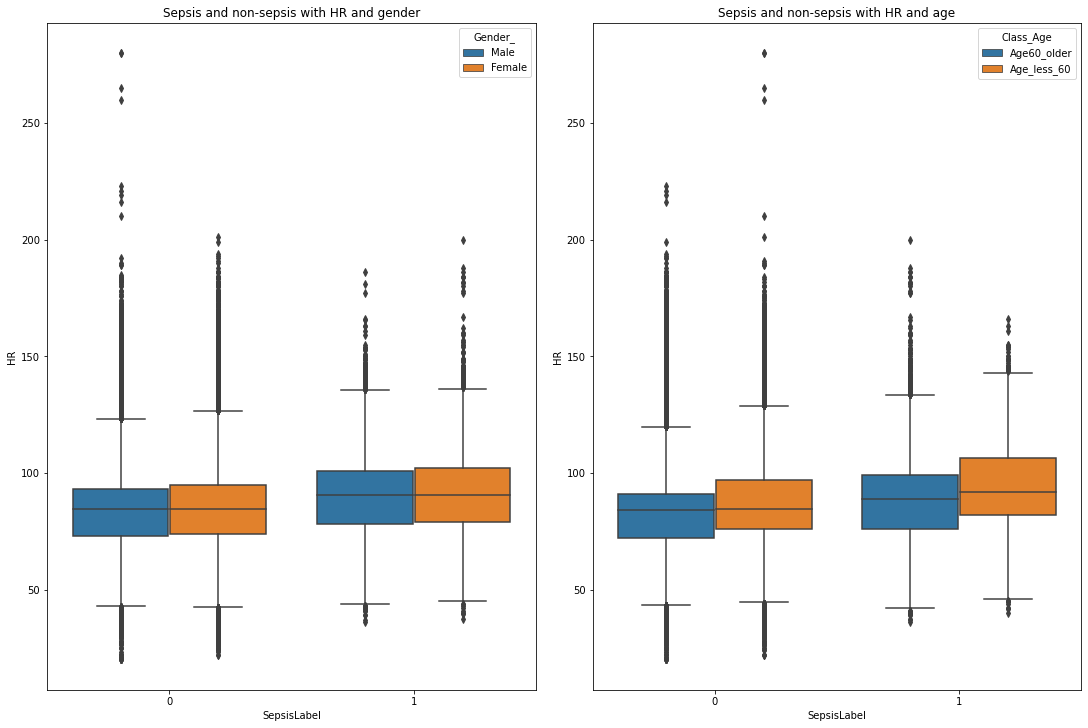

In [125]:
#HR
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(1, 2,figure=fig)

plt.subplot(gs[0,0])
ax2=sns.boxplot(y="HR",x = 'SepsisLabel',hue='Gender_',data=filter_data_copy)
ax2.set_title("Sepsis and non-sepsis with HR and gender")


plt.subplot(gs[0,1])
a5=sns.boxplot(y="HR",x = 'SepsisLabel',hue='Class_Age',data=filter_data_copy)
a5.set_title("Sepsis and non-sepsis with HR and age")

### Sepsis and Temperature (Deg C)

Text(0.5, 1.0, 'Non-sepsis with Temp')

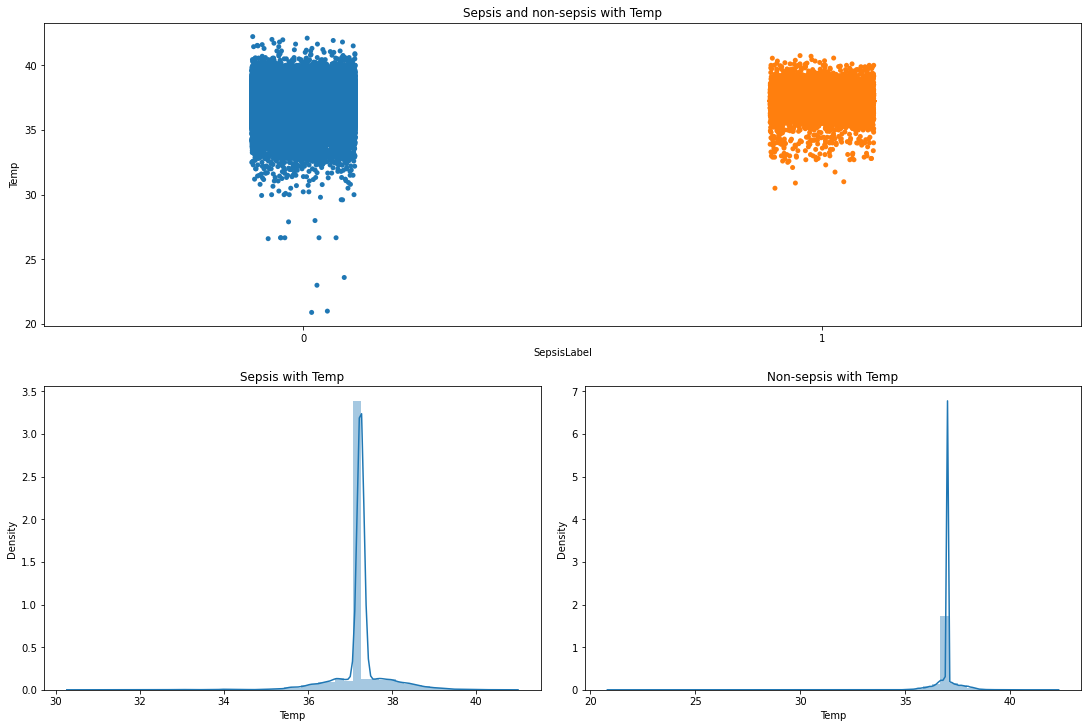

In [127]:
#Sepsis with Temp
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(2, 2,figure=fig)

plt.subplot(gs[0,:])
a5=sns.stripplot(data=filter_data_copy,x='SepsisLabel',y="Temp")
a5.set_title("Sepsis and non-sepsis with Temp")

plt.subplot(gs[1,0])
ax2=sns.distplot(filter_data_copy.loc[index_sepsis1,'Temp'], axlabel='Temp')
ax2.set_title("Sepsis with Temp")

plt.subplot(gs[1,1])
ax3=sns.distplot(filter_data_copy.loc[index_sepsis0,'Temp'], axlabel='Temp')
ax3.set_title("Non-sepsis with Temp")


### Sepsis  with DBP and SBP

Text(0.5, 1.0, 'Non-sepsis with DBP')

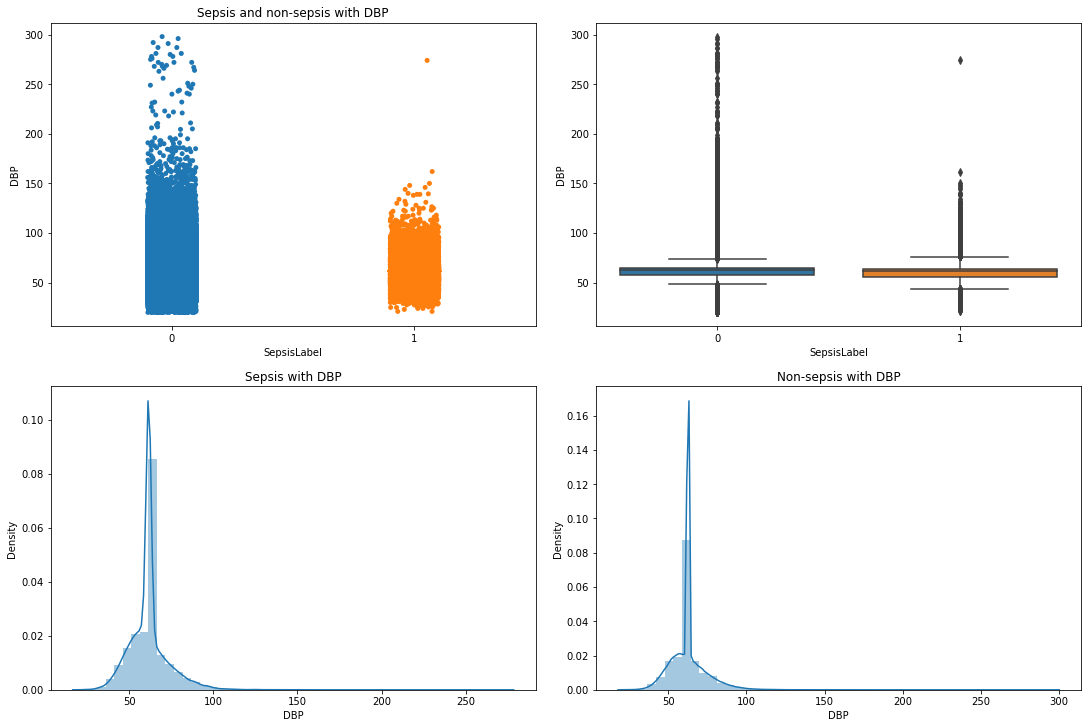

In [129]:
#DBP
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(2, 2,figure=fig)

plt.subplot(gs[0,0])
a5=sns.stripplot(data=filter_data_copy,x='SepsisLabel',y="DBP")
a5.set_title("Sepsis and non-sepsis with DBP")

plt.subplot(gs[0,1])
ax1=sns.boxplot(y="DBP",x = 'SepsisLabel',data=filter_data_copy)
a5.set_title("Sepsis and non-sepsis with DBP")

plt.subplot(gs[1,0])
ax2=sns.distplot(filter_data_copy.loc[index_sepsis1,'DBP'], axlabel='DBP')
ax2.set_title("Sepsis with DBP")

plt.subplot(gs[1,1])
ax3=sns.distplot(filter_data_copy.loc[index_sepsis0,'DBP'], axlabel='DBP')
ax3.set_title("Non-sepsis with DBP")



Text(0.5, 1.0, 'Non-sepsis with SBP')

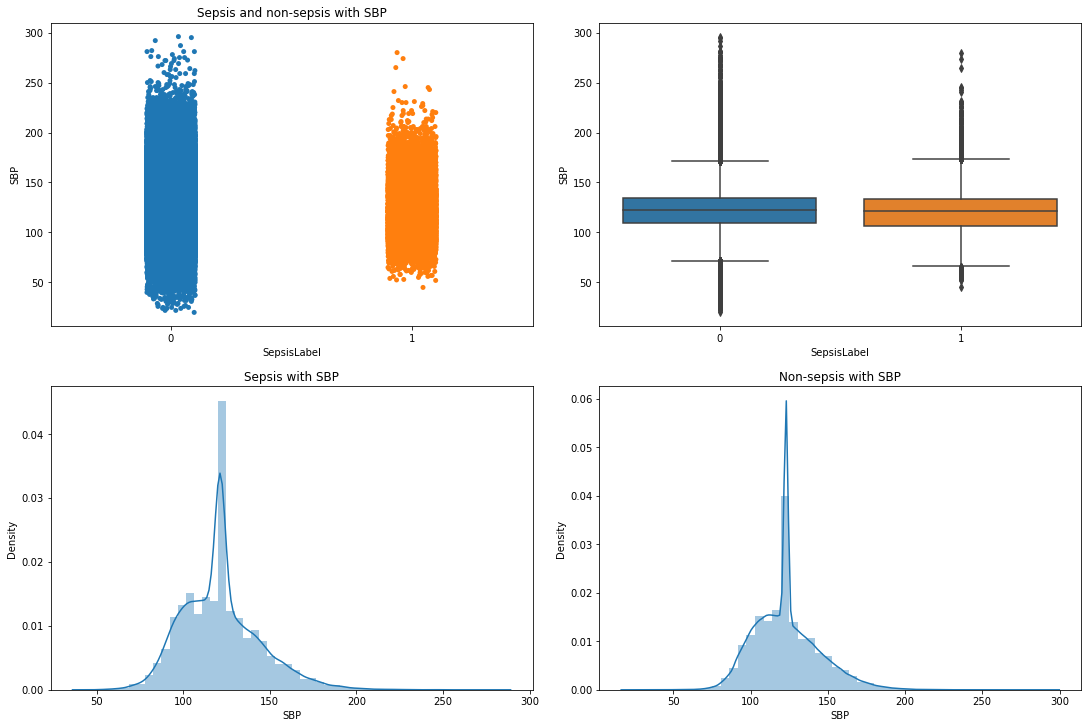

In [130]:
#SBP
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = gridspec.GridSpec(2, 2,figure=fig)

plt.subplot(gs[0,0])
a5=sns.stripplot(data=filter_data_copy,x='SepsisLabel',y="SBP")
a5.set_title("Sepsis and non-sepsis with SBP")

plt.subplot(gs[0,1])
ax1=sns.boxplot(y="SBP",x = 'SepsisLabel',data=filter_data_copy)
a5.set_title("Sepsis and non-sepsis with SBP")

plt.subplot(gs[1,0])
ax2=sns.distplot(filter_data_copy.loc[index_sepsis1,'SBP'], axlabel='SBP')
ax2.set_title("Sepsis with SBP")

plt.subplot(gs[1,1])
ax3=sns.distplot(filter_data_copy.loc[index_sepsis0,'SBP'], axlabel='SBP')
ax3.set_title("Non-sepsis with SBP")

## Model Training and Evaluation

### Imbalanced data 

One of the major problems in statistical modeling is to deal with imbalanced datasets that has an inherent Imbalanced class distribution. In the majority of use-cases involving Bio-medical, Finance, Oil and gas industry which have problem statements like Detection of cancer cells, Fraudulent credit card transaction or Detection of Oil spills are cases when the occurrence of an event are rare instances. The primary goal of a machine learning algorithm is to successfully classify these rare instances into their respective classes.


We have the two main ways of random resampling an imbalanced dataset that includes random oversampling and random undersampling. In our case, we refer to use SMOTENC - Synthetic Minority Over-sampling TEchnique-Nominal Continuous. SMOTENC was generalized to handle mixed datasets of continuous and nominal features.



*Ps: Note that I just try to modeling with 100000 random observations to avoid the heavy running on my computer.*

In [131]:
# data
filter_data_copy2=filter_data_copy.sample(n = 10000) 

In [135]:
print('No Sepsis', round(filter_data_copy2['SepsisLabel'].value_counts()[0]/len(filter_data_copy2) * 100,2), '% of the dataset')
print('Sepsis', round(filter_data_copy2['SepsisLabel'].value_counts()[1]/len(filter_data_copy2) * 100,2), '% of the dataset')

No Sepsis 98.08 % of the dataset
Sepsis 1.92 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Sepsis || 1: Sepsis)')

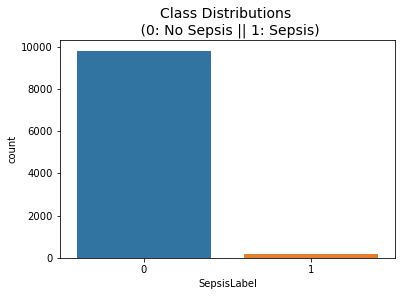

In [138]:
sns.countplot('SepsisLabel', data=filter_data_copy2)
plt.title('Class Distributions \n (0: No Sepsis || 1: Sepsis)', fontsize=14)

In [133]:
filter_data_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 704515 to 337768
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Glucose      10000 non-null  float64
 1   Temp         10000 non-null  float64
 2   Unit1        10000 non-null  object 
 3   Unit2        10000 non-null  object 
 4   DBP          10000 non-null  float64
 5   SBP          10000 non-null  float64
 6   Resp         10000 non-null  float64
 7   O2Sat        10000 non-null  float64
 8   MAP          10000 non-null  float64
 9   HR           10000 non-null  float64
 10  HospAdmTime  10000 non-null  float64
 11  ICULOS       10000 non-null  int64  
 12  Age          10000 non-null  float64
 13  SepsisLabel  10000 non-null  object 
 14  Class_Age    10000 non-null  object 
 15  Gender_      10000 non-null  object 
dtypes: float64(10), int64(1), object(5)
memory usage: 1.3+ MB


In [165]:
#Extracting all the categorical data to be encoded them into numerical data
categorical = []

for col in filter_data_copy2.columns:
    if filter_data_copy2[col].dtype=='object':
        categorical.append(col)
        
print(categorical)

['Unit1', 'Unit2', 'SepsisLabel', 'Class_Age', 'Gender_']


#### Label encoding

It is important to convert the categorical text data into model-understandable OnehotEncoding!

In [167]:
#Label encoding
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder()

label_encoders = {}
for column in categorical:
    label_encoders[column] = LabelEncoder()
    filter_data_copy2[column] = label_encoders[column].fit_transform(filter_data_copy2[column])

In [168]:
filter_data_copy2.head() #check label encoding - Class_Age

Glucose       Temp  Unit1  Unit2        DBP        SBP  Resp  \
704515   136.030007  36.987756      2      2  62.761402  150.00000  28.0   
1087724  136.030007  36.987756      0      1  63.000000  113.00000  26.0   
663328   136.030007  36.390000      1      0  62.761402  122.90108  22.0   
54862    136.030007  36.670000      2      2  62.761402  117.00000  17.0   
603029   136.030007  36.987756      2      2  62.761402  119.00000  27.0   

         O2Sat        MAP     HR  HospAdmTime  ICULOS    Age  SepsisLabel  \
704515    98.0  98.000000   78.0        -3.14      53  53.34            0   
1087724   99.0  91.000000  128.0      -106.04      39  25.00            0   
663328   100.0  81.189362   64.0        -0.02       2  80.60            0   
54862    100.0  79.670000   91.0      -172.60      36  78.51            0   
603029    99.0  60.000000  106.0     -1464.38      33  64.96            0   

         Class_Age  Gender_  
704515           1        0  
1087724          1        1  
663328           0        0  
54862            0        1  
603029           0        0

#### Splitting data into testing and training sets

Before processing the imbalanced data problem by dealing with the method of random under or over sampling, we should split data into the training and testing set separately.

Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.

The main goal is to fit the model either with the dataframes that were undersample and oversample in order for our models to detect the patterns, and test it on the original testing set.

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = filter_data_copy2.drop(['SepsisLabel'], axis=1)
y = filter_data_copy2['SepsisLabel']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#y_test=y_test.astype('int')
#y_train=y_train.astype('int')

In [170]:
y_train.unique()

array([0, 1])

In [171]:
filter_data_copy2.Class_Age.unique()

array([1, 0])

In [172]:
# See if both the train and test label distribution are similarly distributed

train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print('Train distribution: ',train_counts_label/ len(y_train))
print('Test distribution: ',test_counts_label/ len(y_test))

----------------------------------------------------------------------------------------------------
Label Distributions: 

Train distribution:  [0.981125 0.018875]
Test distribution:  [0.9795 0.0205]


In [177]:
#Comparing models
def test_eval(model, X_test, y_test, models=None):
    # Test set prediction
    y_prob=model.predict_proba(X_test)
    y_pred=model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model_name.append(models)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))

In [178]:
precision = list()
recall = list()
F1score = list()
AUCROC = list()
model_name = list()

In [181]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from imblearn.over_sampling import SMOTENC

# SMOTENC
sampling_methods = SMOTENC(categorical_features=[0,2],random_state=0)
x_res, y_res = sampling_methods.fit_resample(x_train, y_train)


classifiers = {"CatBoost" : CatBoostClassifier(verbose=False),
              "LGBM" : LGBMClassifier(),
               "Logistic" : LogisticRegression(),
               "RandomForest" : RandomForestClassifier(),
               "DecisionTree" : DecisionTreeClassifier()
              }
for classifier in classifiers:
    model = classifiers[classifier]
    model.fit(x_res, y_res)
    print('='*60)
    print (classifier, "SMOTENC")
    print('='*60)
    test_eval(model, x_test, y_test, classifier)

CatBoost SMOTENC
Confusion Matrix
[[1959    0]
 [   4   37]] 

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1959
           1       1.00      0.90      0.95        41

    accuracy                           1.00      2000
   macro avg       1.00      0.95      0.97      2000
weighted avg       1.00      1.00      1.00      2000
 

AUC-ROC
0.9977838369501613
LGBM SMOTENC
Confusion Matrix
[[1959    0]
 [   6   35]] 

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1959
           1       1.00      0.85      0.92        41

    accuracy                           1.00      2000
   macro avg       1.00      0.93      0.96      2000
weighted avg       1.00      1.00      1.00      2000
 

AUC-ROC
0.9973729752611462
Logistic SMOTENC
Confusion Matrix
[[1436  523]
 [  19   22]] 

Classification Report
              precision    recall  f1

#### ML models comparing

In [180]:
clf_eval_df = pd.DataFrame({'model':model_name,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})
clf_eval_df

model  precision    recall  f1-score   AUC-ROC
0      CatBoost   1.000000  0.902439  0.948718  0.997784
1          LGBM   1.000000  0.853659  0.921053  0.997373
2      Logistic   0.040367  0.536585  0.075085  0.684209
3  RandomForest   0.972222  0.853659  0.909091  0.997466
4  DecisionTree   0.878049  0.878049  0.878049  0.937748

## Perpectives:

* We can optimize hyparameters of each ML algorithms to get better results. 

* Try with other ML algoritms, such as XGboost, SVM, etc.

* Consider the time component for the data, particularly, sepsis is diagnosed for each patient at each hour using the past data. Hence, we can such use popular models: LSTM, Prophet, ARIMA, etc. 